<a href="https://colab.research.google.com/github/karentp/NaiveBayesExample/blob/main/NaiveBayesEjemplo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Ejemplo clasificador con algoritmo Naive Bayes


$P(X|Y) = P(Y|X) * \frac{P(X)}{P(Y)}$

Importamos las librerías para hacer cálculos, como estamos usando python usamos las más comunes para manejo de datos:

#Algoritmo

In [644]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

Como los parámetros de los datasets son continuos (tienden a algo), lo más común es escoger una distribución Gaussiana (en forma de campana), se necesita escoger el tipo de distribución para calcular los likelihood de cada probabilidad

In [645]:
class NaiveBayesClassifier():

      def calc_statistics(self, features, target):
        '''
        Calculamos la media y la varianza de cada columna(cada feature o característica), 
        luego las transformamos en arrys de numpy. La media y la varianza son necesarias 
        para calcular la distribución Gaussiana.
        ''' 
        self.mean = features.groupby(target).apply(np.mean).to_numpy()
        self.var = features.groupby(target).apply(np.var).to_numpy()
              
        return self.mean, self.var


      def gaussian_density(self, class_idx, x):     
        '''
        Calculamos la probabilidad de la distribución Gaussiana. La fórmula para la probabilidad
        de la función de densidad Gaussiana es:
        (1/√2pi*σ) * exp((-1/2)*((x-μ)^2)/(2*σ²)), 
        
        donde μ es la media, σ² es la varianza, σ es la desviación estándar (raíz cuadrada de la varianza)
        '''
        mean = self.mean[class_idx]
        var = self.var[class_idx]
        numerator = np.exp((-1/2)*((x-mean)**2) / (2 * var))
        denominator = np.sqrt(2 * np.pi * var)
        prob = numerator / denominator
        return prob

      def calc_prior(self, features, target):
        '''
        calcular la probabilidad previa P(Y)
        '''
        self.prior = (features.groupby(target).apply(lambda x: len(x)) / self.rows).to_numpy()

        return self.prior

      def calc_posterior(self, x):
        """
        Calcular la probabilidad posterior para cada clase P(X|Y)
        """
        posteriors = []
        for i in range(self.count):
            ## se usa el logaritmo para hacerlo más estable y evitar underflow
            prior = np.log(self.prior[i]) 
            conditional = np.sum(np.log(self.gaussian_density(i, x))) 
            posterior = prior + conditional
            posteriors.append(posterior)
        #returna la clase con la probabilidad posterior más alta
        return self.classes[np.argmax(posteriors)]

      def fit(self, features, target):
        """definir las clases y los features"""
        self.classes = np.unique(target)
        self.count = len(self.classes)
        self.feature_nums = features.shape[1]
        self.rows = features.shape[0]
        
        """ calcular las estadisticas """  
        self.calc_statistics(features, target)

        """ calcular la probabilidad previa"""
        self.calc_prior(features, target)
            
      def predict(self, features):
        """
        Calcular la probabilidad posterior con los features de cada clase
        """
        preds = [self.calc_posterior(f) for f in features.to_numpy()]
        return preds

      def accuracy(self, y_test, y_pred):
        """
        Función para comparar este algoritmo y el ground truth
        """
        accuracy = np.sum(y_test == y_pred) / len(y_test)
        return accuracy

      def visualize(self, y_true, y_pred, target):

        """
        Función para visualizar los resultados
        """
        
        tr = pd.DataFrame(data=y_true, columns=[target])
        pr = pd.DataFrame(data=y_pred, columns=[target])

        fig, ax = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(15,6))
        
        sns.countplot(x=target, data=tr, ax=ax[0], palette='rocket', alpha=0.7, hue=target, dodge=False)
        sns.countplot(x=target, data=pr, ax=ax[1], palette='rocket', alpha=0.7, hue=target, dodge=False)
        
        fig.suptitle('Ground truth (Verdad fundamental) vs Predicción Naive Bayes', fontsize=20)

        ax[0].tick_params(labelsize=12)
        ax[1].tick_params(labelsize=12)
        ax[0].set_title("Valores reales", fontsize=18)
        ax[1].set_title("Valores predecidos", fontsize=18)
        plt.show()

      def visualize_error(self, y_true, y_pred, target):

        """
        Función para visualizar los errores
        """
        
        tr = pd.DataFrame(data=y_true, columns=[target])
        pr = pd.DataFrame(data=y_pred, columns=[target])
        
        errordf = pr.value_counts().sub(tr.value_counts())

        errores = {u'Setosa':int(np.abs(errordf['Setosa']/tr.value_counts()['Setosa'])*100),
                   u'Versicolor': int(np.abs(errordf['Versicolor']/tr.value_counts()['Versicolor']*100)),
                   u'Virginica':int(np.abs(errordf['Virginica']/tr.value_counts()['Virginica']*100))}
        
        print("Valores esperados: \n", tr.value_counts())

        print("\n Valores obtenidos: \n", pr.value_counts())

        print("\n Cantidad de errores: \n", errordf)

        plt.bar(*zip(*errores.items()),color='magenta')
        plt.title('Error porcentual respecto al los valores esperados')
        plt.xlabel("Variedad")
        plt.ylabel("Error porcentual")
        plt.show()


#Preparación del dataset

Accedemos a la carpeta de drive donde está el dataset

In [646]:
from google.colab import drive
drive.mount('/content/drive')
%cd ./drive/MyDrive/UCR/2021/'II-2021'/IA/NaiveBayes

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[Errno 2] No such file or directory: './drive/MyDrive/UCR/2021/II-2021/IA/NaiveBayes'
/content/drive/MyDrive/UCR/2021/II-2021/IA/NaiveBayes


Procesamos el dataset para realizar el entrenamiento

In [647]:
""" Leemos el dataset con Pandas -  la información es (150 filas, 5 col)"""
dataset = pd.read_csv("/content/drive/MyDrive/UCR/2021/II-2021/IA/NaiveBayes/iris.csv")

""" Mezclar el dataset con muestra"""
dataset = dataset.sample(frac=1, random_state=1).reset_index(drop=True)


Dataset

In [648]:
""" Tamaño de dataset"""
print("tamaño del dataset:", dataset.shape)
print("\n")
print("Dataset: ")
dataset

tamaño del dataset: (150, 5)


Dataset: 


,sepal.length,sepal.width,petal.length,petal.width,variety
0,5.8,4.0,1.2,0.2,Setosa
1,5.1,2.5,3.0,1.1,Versicolor
2,6.6,3.0,4.4,1.4,Versicolor
3,5.4,3.9,1.3,0.4,Setosa
4,7.9,3.8,6.4,2.0,Virginica
...,...,...,...,...,...
145,6.3,2.8,5.1,1.5,Virginica
146,6.4,3.1,5.5,1.8,Virginica
147,6.3,2.5,4.9,1.5,Versicolor
148,6.7,3.1,5.6,2.4,Virginica


Indicamos cuales son los features y cual es el targe

In [649]:
""" Establecer los features y el objetivo"""
X, y = dataset.iloc[:, :-1], dataset.iloc[:, -1]

print("Características \n", X)
print("\n Objetivo \n", y)

Características 
      sepal.length  sepal.width  petal.length  petal.width
0             5.8          4.0           1.2          0.2
1             5.1          2.5           3.0          1.1
2             6.6          3.0           4.4          1.4
3             5.4          3.9           1.3          0.4
4             7.9          3.8           6.4          2.0
..            ...          ...           ...          ...
145           6.3          2.8           5.1          1.5
146           6.4          3.1           5.5          1.8
147           6.3          2.5           4.9          1.5
148           6.7          3.1           5.6          2.4
149           4.9          3.6           1.4          0.1

[150 rows x 4 columns]

 Objetivo 
 0          Setosa
1      Versicolor
2      Versicolor
3          Setosa
4       Virginica
          ...    
145     Virginica
146     Virginica
147    Versicolor
148     Virginica
149        Setosa
Name: variety, Length: 150, dtype: object


Partimos el dataset para utilizar una parte como training y otra parte para evaluar. 
Se escogió 70% (100) para entrenar y 30% (50) para evaluar

In [650]:
X_train, X_test, y_train, y_test = X[:100], X[100:], y[:100], y[100:]


Tamaño del dataset de entranamiento:

In [651]:
X_train.shape

(100, 4)

Instanciamos el clasificador

In [652]:
x = NaiveBayesClassifier()

Las clases

In [653]:
x.fit(X_train, y_train)
x.classes

array(['Setosa', 'Versicolor', 'Virginica'], dtype=object)

El número de características

In [654]:
x.feature_nums

4

Calcular la probabilidad previa

In [655]:
x.calc_prior(X_train, y_train)
x.prior

array([0.31, 0.32, 0.37])

Calculamos la media y la varianza para la distribución Gaussiana a la hora de calcular las probilidades posteriores

In [656]:
x.calc_statistics(X_train, y_train)

(array([[5.08387097, 3.50322581, 1.46129032, 0.24516129],
        [5.9125    , 2.790625  , 4.275     , 1.33125   ],
        [6.71891892, 2.98918919, 5.63243243, 2.05675676]]),
 array([[0.11361082, 0.10934443, 0.02430801, 0.0089282 ],
        [0.21296875, 0.08272461, 0.185625  , 0.03214844],
        [0.3566691 , 0.11339664, 0.32867787, 0.0592111 ]]))

Realizar todos los cálculos anteriores y calcular la probabilidad posterior para cada clase

In [657]:
predictions = x.predict(X_test)

Calcular la precisión

In [658]:
x.accuracy(y_test, predictions)

0.92

In [659]:
y_test.value_counts(normalize=True)

Setosa        0.38
Versicolor    0.36
Virginica     0.26
Name: variety, dtype: float64

#Visualización, análisis y resultados

<Figure size 800x640 with 0 Axes>

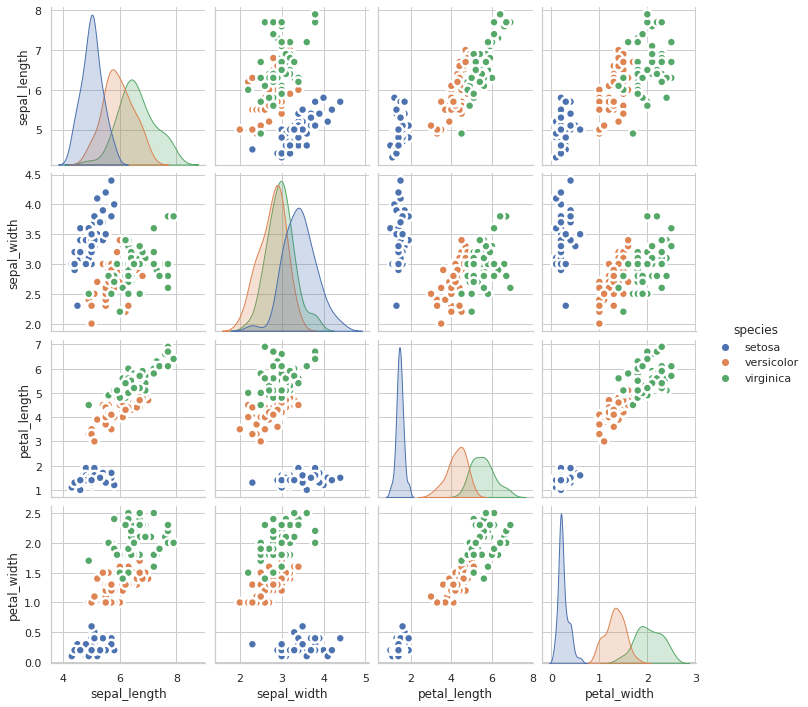

In [660]:
# Load Dataset
df = sns.load_dataset('iris')

# Plot
plt.figure(figsize=(10,8), dpi= 80)
sns.pairplot(df, kind="scatter", hue="species", plot_kws=dict(s=80, edgecolor="white", linewidth=2.5))
plt.show()

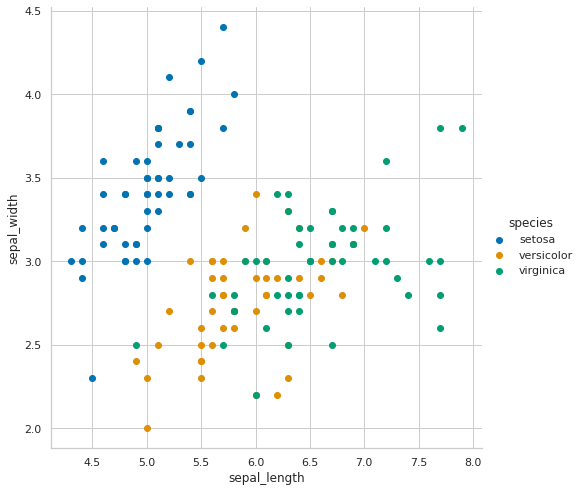

In [661]:
import matplotlib.colors as colors

# Our 2-dimensional classifier will be over variables X and Y
N = 100
X = np.linspace(4, 8, N)
Y = np.linspace(1.5, 5, N)
X, Y = np.meshgrid(X, Y)

color_list = ['Blues','Greens','Reds']
my_norm = colors.Normalize(vmin=-1.,vmax=1.)

iris = sns.load_dataset("iris")
iris = iris.rename(index = str, columns = {'sepal_length':'sepal_length','sepal_width':'sepal_width', 'petal_length':'petal_length', 'petal_width':'petal_width'})
g = sns.FacetGrid(iris, hue="species", height=7, palette = 'colorblind') .map(plt.scatter, "sepal_length", "sepal_width",)  .add_legend()
my_ax = g.ax



In [662]:
from plotly.express import scatter_3d
df = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/2014_apple_stock.csv')
scatter_3d(dataset, x='sepal.length', y='sepal.width', z='petal.length', size="petal.width",
                   color="variety", color_discrete_map={"Joly": "blue", "Bergeron": "violet", "Coderre": "pink"})\
            .show()

#Ground Truth vs Predicción

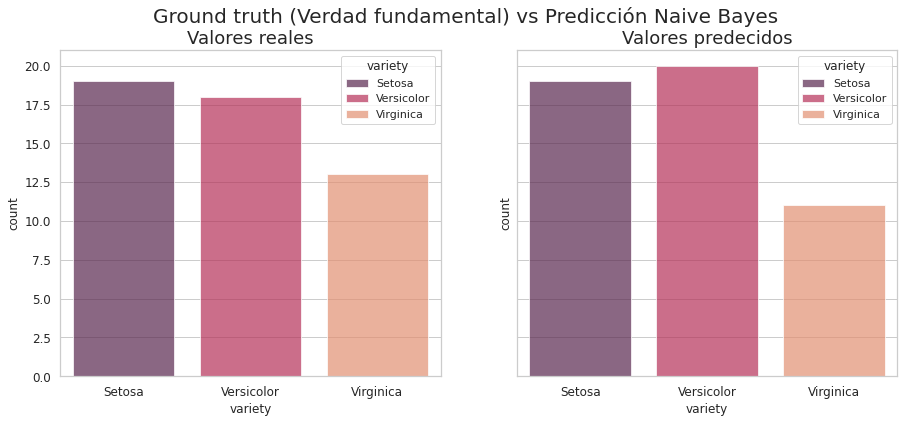

In [663]:
x.visualize(y_test, predictions, 'variety')

#Error

Valores esperados: 
 variety   
Setosa        19
Versicolor    18
Virginica     13
dtype: int64

 Valores obtenidos: 
 variety   
Versicolor    20
Setosa        19
Virginica     11
dtype: int64

 Cantidad de errores: 
 variety   
Setosa        0
Versicolor    2
Virginica    -2
dtype: int64


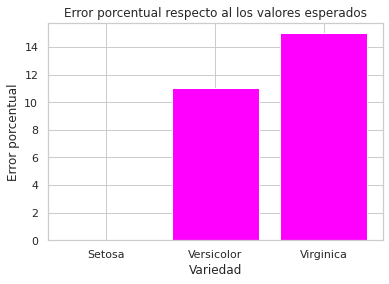

In [664]:
x.visualize_error(y_test, predictions, 'variety')